<a href="https://colab.research.google.com/github/SupermarketAutomationAI/PrimaryModel_1/blob/main/primary_model_JX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the Data - V1

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip '/content/drive/MyDrive/Colab Notebooks/APS360/Project/Dataset/V3_combined_all_DS.zip' -d '/root/datasets'

Split the data

In [3]:
# Import the necessary libraries
import json
import os
import math
import shutil

In [4]:
# create data directory and move all images into it
parent_dir = "/root/datasets/V3_combined_all_DS"
os.chdir(parent_dir)
category_list = list(filter(lambda x: os.path.isdir(x), os.listdir()))
data_dir = parent_dir + '/' + "data"
os.mkdir(data_dir, 755)
for category in category_list:
    cat_dir = parent_dir + '/' + category
    shutil.move(cat_dir, data_dir)

In [5]:
train_split = 0.6

classes_with_no_files = []

dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
    path = parent_dir + '/'+ dsdirs
    if os.path.exists(path):
      shutil.rmtree(path)
    os.mkdir( path, 755 )

for category in category_list: 
    src_path = parent_dir + '/data/' + category
    train_dir = parent_dir + '/train/' + category + '/'
    val_dir = parent_dir + '/val/' + category + '/'
    test_dir = parent_dir + '/test/' + category + '/'
    
    os.mkdir(train_dir, 755 )
    os.mkdir(val_dir, 755)
    os.mkdir(test_dir, 755)

    #get files' names list from respective directories
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]

    #get training, testing and validation files count
    train_count = math.ceil(train_split*len(files))
    valid_count = int((len(files)-train_count)/2)
    test_count = valid_count

    #get files to segragate for train,test and validation data set
    train_data_list = files[0: train_count-1]
    valid_data_list = files[train_count:train_count+valid_count-1] 
    test_data_list = files[train_count+valid_count:]


    for train_data in train_data_list:
        train_path = src_path + '/' + train_data
        shutil.move(train_path,train_dir)

    for valid_data in valid_data_list:
        valid_path = src_path + '/' + valid_data
        shutil.move(valid_path,val_dir)

    for test_data in test_data_list:
        test_path = src_path + '/' + test_data
        shutil.move(test_path,test_dir)

    # Move any files that are left behind into the training directory
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    for img_left_behind in files:
        img_path = src_path + '/' + img_left_behind
        shutil.move(img_path, train_dir)
    
    # TODO: Print number of files in directory, and compute the actual split porportions
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    src_files = len(files)
    print("SRC - {} : {} files".format(category, src_files))
    os.chdir(train_dir)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    train_files = len(files)
    print("TRAIN - {} : {} files".format(category, train_files))
    os.chdir(val_dir)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    val_files = len(files)
    print("VAL - {} : {} files".format(category, val_files))
    os.chdir(test_dir)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    test_files = len(files)
    print("TEST - {} : {} files".format(category, test_files))

    total_files = train_files + val_files + test_files
    if total_files is 0:
      # some class directories have children directories with all the photos
      # will skip these classes
      classes_with_no_files.append(category)
      continue;
    print("Split: {}% training, {}% validation, and {}% test".
          format((train_files/total_files * 100), (val_files/total_files * 100), 
                 (test_files/total_files * 100)))
    
#####
print("\n\n!!!WARNING!!! the following classes are empty:")
print(classes_with_no_files)

SRC - Carambola : 0 files
TRAIN - Carambola : 2497 files
VAL - Carambola : 831 files
TEST - Carambola : 832 files
Split: 60.02403846153847% training, 19.97596153846154% validation, and 20.0% test
SRC - Granny_Smith_Apple : 0 files
TRAIN - Granny_Smith_Apple : 1235 files
VAL - Granny_Smith_Apple : 410 files
TEST - Granny_Smith_Apple : 411 files
Split: 60.068093385214006% training, 19.941634241245136% validation, and 19.990272373540858% test
SRC - Peach : 0 files
TRAIN - Peach : 3156 files
VAL - Peach : 1050 files
TEST - Peach : 1052 files
Split: 60.02282236591861% training, 19.9695701787752% validation, and 20.0076074553062% test
SRC - Orange : 0 files
TRAIN - Orange : 3616 files
VAL - Orange : 1203 files
TEST - Orange : 1205 files
Split: 60.0265604249668% training, 19.97011952191235% validation, and 20.00332005312085% test
SRC - Banana : 0 files
TRAIN - Banana : 3630 files
VAL - Banana : 1208 files
TEST - Banana : 1210 files
Split: 60.019841269841265% training, 19.973544973544975% vali

In [6]:
# Remove hidden files & directories that break data loader
dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
  path = parent_dir + '/'+ dsdirs
  !find $path -name '._*' -delete
  print("Deleted ._* files from {0}".format(path))

Deleted ._* files from /root/datasets/V3_combined_all_DS/train
Deleted ._* files from /root/datasets/V3_combined_all_DS/val
Deleted ._* files from /root/datasets/V3_combined_all_DS/test


# Using AlexNet for feature extraction

In [7]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models

In [8]:
# List different classes
'''
# V1 dataset
classes = ['Multiple Bananas', 'Multiple Fuji Apples', 'Multiple Gala Apples', 'Multiple Golden Delicious Apples', 
           'Multiple Granny Smith Apples', 'Multiple Oranges', 'Multiple Red Delicious Apples',
           'One Banana', 'One Fuji Apple', 'One Gala Apple', 'One Golden Delicious Apple',
           'One Granny Smith Apple', 'One Orange', 'One Red Delicious Apple']
# V2 dataset
classes = ['Banana', 'Fuji_Apple', 'Gala_Apple', 'Golden_Delicious_Apple', 
           'Granny_Smith_Apple', 'Orange', 'Red_Delicious_Apple']
'''
# V3 dataset
classes = ['Banana', 'Carambola', 'Fuji_Apple', 'Gala_Apple', 'Golden_Delicious_Apple', 
           'Granny_Smith_Apple', 'Guava', 'Kiwi', 'Mango', 'Orange', 
           'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate',
           'Red_Delicious_Apple', 'Tomatoes', 'muskmelon']

In [9]:
# Get pretrained weights from the internet
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [11]:
def get_relevant_indices(dataset, classes, target_classes):
  '''
  Return the indices for datapoints in the dataset that belongs to the desired
  target classes
  '''
  indices = []
  for i in range(len(dataset)):
    # Check if the label is in the target class
    label_index = dataset[i][1]
    label_class = classes[label_index]
    if label_class in target_classes:
      indices.append(i)
  return indices

In [12]:
# Assumptions:
# - resize to 224 by 224
def get_alexnet_features(path, classes, target_classes, verify=False):
  '''
  Loads the images from the datasets folder and computes the AlexNet features
  then save those computed features
  '''
  start_time = time.time()
  # transform settings
  transform = transforms.Compose([transforms.Resize((224,224)), 
                                  transforms.ToTensor()])
  
  # load data from given path, data is already split into 3 folders
  train_dataset = torchvision.datasets.ImageFolder(path + '/train', transform=transform)
  val_dataset = torchvision.datasets.ImageFolder(path + '/val', transform=transform)
  test_dataset = torchvision.datasets.ImageFolder(path + '/test', transform=transform)

  # load data with batch size of 1 since each image needs to be saved 1 at a time
  batch_size = 1
  num_workers = 1
  train_sampler = SubsetRandomSampler(get_relevant_indices(train_dataset, classes, target_classes))
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=train_sampler)
  val_sampler = SubsetRandomSampler(get_relevant_indices(val_dataset, classes, target_classes))
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=val_sampler)
  test_sampler = SubsetRandomSampler(get_relevant_indices(test_dataset, classes, target_classes))
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=test_sampler)

  # save features to folders as tensors
  ###TRAIN###
  if os.path.exists(path + '/train/features'):
    # may contain old data
    shutil.rmtree(path + '/train/features')
    print("Found /train/features exists, removed.")

  n = 0
  fig = plt.figure(figsize=(32, 4)) #for verify later on
  print("Saving training data features...")
  for img, label in train_loader: 
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = path + '/train/features'
    if not os.path.isdir(folder_name):
      #create features dir if it doesn't exist
      os.mkdir(folder_name)
    folder_name += '/' + str(classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)

    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

    if verify is True and n <= 20:
      # verification step
      image = img.numpy() #convert to numpy for display
      ax = fig.add_subplot(2, 20/2, n, xticks=[], yticks=[])
      plt.imshow(np.transpose(image[0], (1, 2, 0)))
      ax.set_title(classes[label[0]])

  ###VALIDATION###
  if os.path.exists(path + '/val/features'):
    # may contain old data
    shutil.rmtree(path + '/val/features')
    print("Found /val/features exists, removed.")

  n=0
  print("Saving validation data features...")
  for img, label in val_loader:
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = path + '/val/features'
    if not os.path.isdir(folder_name):
      #create features dir if it doesn't exist
      os.mkdir(folder_name)
    folder_name += '/' + str(classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)

    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1
  
  ###TEST###
  if os.path.exists(path + '/test/features'):
    # may contain old data
    shutil.rmtree(path + '/test/features')
    print("Found /test/features exists, removed.")

  n=0
  print("Saving test data features...")
  for img, label in val_loader:
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = path + '/test/features'
    if not os.path.isdir(folder_name):
      #create features dir if it doesn't exist
      os.mkdir(folder_name)
    folder_name += '/' + str(classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)

    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1
  
  end_time = time.time()
  print("Total time:  % 6.2f s" % ( end_time-start_time))
  return

In [13]:
# List all directories because there seems to be a lot of hidden directories
dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
  path = parent_dir + '/'+ dsdirs
  stuff = os.listdir(path)
  print(stuff)
  !find $path -name '.*' -delete

['Carambola', 'Granny_Smith_Apple', 'Peach', 'Orange', 'Banana', 'Gala_Apple', 'Pitaya', 'Pear', 'Kiwi', 'Pomegranate', 'Mango', 'Golden_Delicious_Apple', 'Red_Delicious_Apple', 'Tomatoes', 'Persimmon', 'Guava', 'Plum', 'Fuji_Apple', 'muskmelon']
['Carambola', 'Granny_Smith_Apple', 'Peach', 'Orange', 'Banana', 'Gala_Apple', 'Pitaya', 'Pear', 'Kiwi', 'Pomegranate', 'Mango', 'Golden_Delicious_Apple', 'Red_Delicious_Apple', 'Tomatoes', 'Persimmon', 'Guava', 'Plum', 'Fuji_Apple', 'muskmelon']
['Carambola', 'Granny_Smith_Apple', 'Peach', 'Orange', 'Banana', 'Gala_Apple', 'Pitaya', 'Pear', 'Kiwi', 'Pomegranate', 'Mango', 'Golden_Delicious_Apple', 'Red_Delicious_Apple', 'Tomatoes', 'Persimmon', 'Guava', 'Plum', 'Fuji_Apple', 'muskmelon']


Saving training data features...
Saving validation data features...
Saving test data features...
Total time:   363.81 s


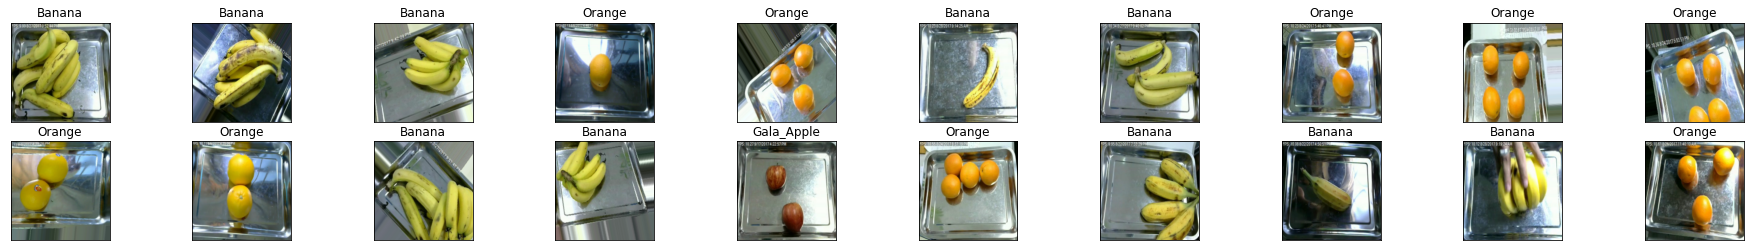

In [13]:
# Test image loader
target_classes = ['Orange', 'Gala_Apple', 'Banana']
get_alexnet_features(parent_dir, classes, target_classes, verify=True)

In [14]:
def get_feature_loader(path, batch_size=32):
    '''
    Loads saved tensor files with features extracted using AlexNet
    '''
    # load tensor files from folder
    train_dataset = torchvision.datasets.DatasetFolder(path + '/train/features/', loader=torch.load, extensions=('.tensor'))
    val_dataset = torchvision.datasets.DatasetFolder(path + '/val/features/', loader=torch.load, extensions=('.tensor'))
    test_dataset = torchvision.datasets.DatasetFolder(path + '/test/features/', loader=torch.load, extensions=('.tensor'))

    # Prepare Dataloader
    num_workers = 1
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

    # Verification Step - obtain one batch of features
    data_iter = iter(train_loader)
    features, labels = data_iter.next()
    print("Training Shape:")
    print(features.shape)
    print(labels.shape)

    data_iter = iter(val_loader)
    features, labels = data_iter.next()
    print("Validation Shape:")
    print(features.shape)
    print(labels.shape)

    data_iter = iter(test_loader)
    features, labels = data_iter.next()
    print("Test Shape:")
    print(features.shape)
    print(labels.shape)
    print('\n')

    return train_loader, val_loader, test_loader

In [15]:
# Load saved AlexNet features, batch size 64
train_loader, val_loader, test_loader = get_feature_loader(parent_dir, batch_size=64)

Training Shape:
torch.Size([64, 256, 6, 6])
torch.Size([64])
Validation Shape:
torch.Size([64, 256, 6, 6])
torch.Size([64])
Test Shape:
torch.Size([64, 256, 6, 6])
torch.Size([64])




# CNN Model Architecture

Architecture:

Start with 1 convolution and 1 pooling layer then a FC layer

In [16]:
torch.manual_seed(1) # set the random seed

class AlexNetCNNClassifier(nn.Module):
    def __init__(self):
        super(AlexNetCNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(256, 128, 3) # creates 4x4 feature map
        self.pool = nn.MaxPool2d(2, 2) # createst 2x2 feature map
        self.fc1 = nn.Linear(128*2*2, 17) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 128*2*2)
        x = self.fc1(x)
        return x

In [17]:
def get_accuracy_AlexNet(model, data_loader, use_cuda=False):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train_AlexNet(model, train_loader, val_loader, num_epochs=1, batch_size=32, learn_rate=0.001, use_cuda=False):
    # Note train_loader = feature_loader

    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    iters, train_acc, val_acc = [], [], []

    # training
    print ("Training Started...")
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):

        for imgs, labels in iter(train_loader):
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            out = model(imgs)       # forward pass, imgs already the features extracted from AlexNet
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1

        # save the current training information
        iters.append(n)
        train_acc.append(get_accuracy_AlexNet(model, train_loader)) # compute training accuracy
        val_acc.append(get_accuracy_AlexNet(model, val_loader))  # compute validation accuracy
        print("Epoch {0} | Training Accuracy: {1} | Validation Accuracy: {2}".format(epoch + 1, train_acc[-1], val_acc[-1]))

    end_time= time.time()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

Tune Hyperparameter with All Datasets

Saving training data features...
Saving validation data features...
Saving test data features...
Total time:   1803.45 s


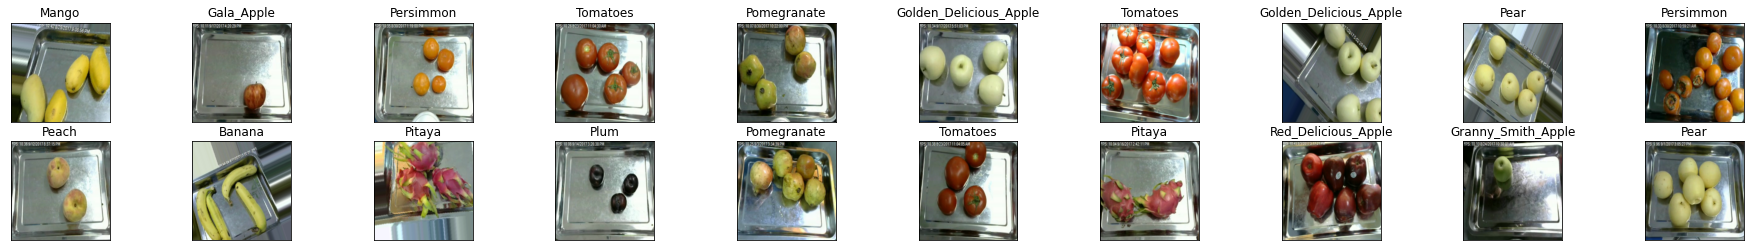

In [15]:
# exclude kiwi and guava which have a weird file structure
target_classes = ['Banana', 'Carambola', 'Fuji_Apple', 'Gala_Apple', 'Golden_Delicious_Apple', 
                  'Granny_Smith_Apple','Mango', 'Orange', 
                  'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate',
                  'Red_Delicious_Apple', 'Tomatoes', 'muskmelon']
get_alexnet_features(parent_dir, classes, target_classes, verify=True)

Training Shape:
torch.Size([64, 256, 6, 6])
torch.Size([64])
Validation Shape:
torch.Size([64, 256, 6, 6])
torch.Size([64])
Test Shape:
torch.Size([64, 256, 6, 6])
torch.Size([64])


Training Started...
Epoch 1 | Training Accuracy: 0.9905608755129959 | Validation Accuracy: 0.9821452725551197
Epoch 2 | Training Accuracy: 0.993296853625171 | Validation Accuracy: 0.9820100094684161
Epoch 3 | Training Accuracy: 0.995485636114911 | Validation Accuracy: 0.9866089544163398
Epoch 4 | Training Accuracy: 0.9999088007295942 | Validation Accuracy: 0.9947247396185581
Epoch 5 | Training Accuracy: 0.9896032831737346 | Validation Accuracy: 0.9780873799540105
Epoch 6 | Training Accuracy: 0.9982672138622891 | Validation Accuracy: 0.9883673745434871
Epoch 7 | Training Accuracy: 0.9970360237118103 | Validation Accuracy: 0.9905315839307453
Epoch 8 | Training Accuracy: 0.9931144550843594 | Validation Accuracy: 0.9844447450290815
Epoch 9 | Training Accuracy: 0.9999088007295942 | Validation Accuracy: 0.993777

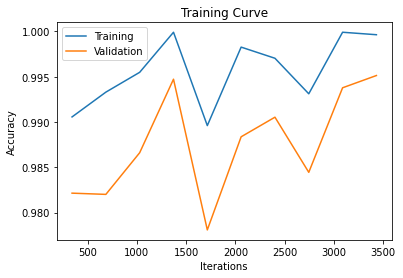

Final Training Accuracy: 0.9996352029183766
Final Validation Accuracy: 0.995130528878669
Total time:   296.52 s  Time per Epoch:  29.65 s 


In [19]:
# With 17 classes and V3
model = AlexNetCNNClassifier()
train_loader, val_loader, test_loader = get_feature_loader(parent_dir, batch_size=64) # reload AlexNet features with new batch_size
train_AlexNet(model, train_loader, val_loader, batch_size=64, num_epochs=10)